In [28]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaModel
import warnings

warnings.filterwarnings('ignore')

This notebook contains analysis of approaches to evaluate the drop in toxicity, ratio of preserved meaning, and the grammatical and semantical soundness of the translation 

In [3]:
data = pd.read_csv('../data/interim/filtered.tsv', sep='\t')
del data["Unnamed: 0"]

In [4]:
data.head()

,reference,translation,similarity,ref_tox,trn_tox,length_diff
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.014195,0.981983,0.010309
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.065473,0.999039,0.071429
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.213313,0.985068,0.268293
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.053362,0.994215,0.309524
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.009402,0.999348,0.181818


One option is to use some BERT-like model for similarity estimation (sentence pair classification), and find third-source model for sentence tox_level estimation 

In [76]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
model.eval()

probs = []
test_len = 500
with torch.no_grad():
    for i in tqdm(range(test_len)):
        row = data.iloc[i]
        sentence1 = row.reference
        sentence2 = row.translation
        inputs = tokenizer(sentence1, sentence2, return_tensors='pt')
        logits = model(**inputs)[0]
        probs.append(float(torch.softmax(logits, dim=1)[0][0]))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/500 [00:00<?, ?it/s]

[[1.         0.08024862]
 [0.08024862 1.        ]]


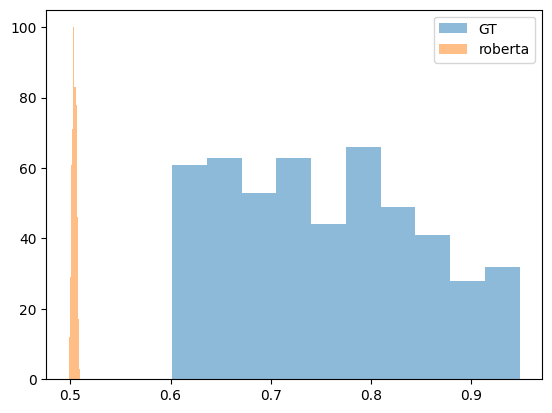

In [77]:
plt.hist(data.similarity.to_numpy()[:test_len], alpha=0.5, label='GT', density=False)
plt.hist(np.array(probs), alpha=0.5, label='roberta', density=False)
plt.legend();
print(np.corrcoef(data.similarity.to_numpy()[:test_len], np.array(probs)))

This approach does not work very well, an alternative is to measure cos_sim between CLS tokens

In [74]:
similarities_roberta = []
# This code could be optmized by pipeline ( https://huggingface.co/transformers/v3.0.2/main_classes/pipelines.html#transformers.FeatureExtractionPipeline )
#   but right now its just hypothesis testing
roberta_model = RobertaModel.from_pretrained('roberta-base')
roberta_model.eval()
test_len = 500

with torch.no_grad():
    for i in tqdm(range(test_len)):
        row = data.iloc[i]
        sentence1 = row.reference
        sentence2 = row.translation
        
        encoding1 = tokenizer(sentence1, return_tensors='pt')
        encoding2 = tokenizer(sentence2, return_tensors='pt')
        
        embedding1 = roberta_model(**encoding1).last_hidden_state[:,0,:].numpy().squeeze()
        embedding2 = roberta_model(**encoding2).last_hidden_state[:,0,:].numpy().squeeze()
        
        cos_sim = embedding1.T @ embedding2 / np.linalg.norm(embedding1) / np.linalg.norm(embedding2)
        similarities_roberta.append(cos_sim)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/500 [00:00<?, ?it/s]

[[1.         0.20794835]
 [0.20794835 1.        ]]


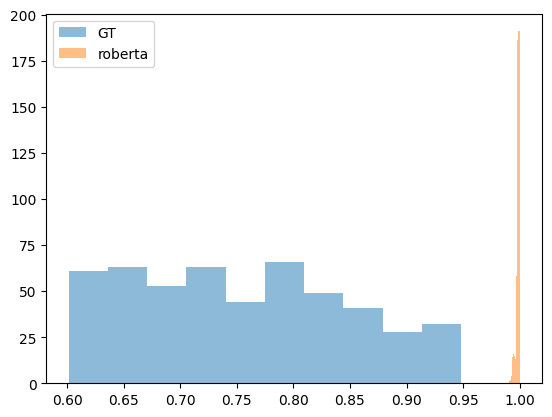

In [75]:
plt.hist(data.similarity.to_numpy()[:test_len], alpha=0.5, label='GT', density=False)
plt.hist(np.array(similarities_roberta), alpha=0.5, label='roberta', density=False)
plt.legend();
print(np.corrcoef(data.similarity.to_numpy()[:test_len], np.array(similarities_roberta)))

So these estimations are too positive

Let's try another model from huggingface:

In [86]:
# Code adapted from https://huggingface.co/sentence-transformers/all-mpnet-base-v2
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

similarities_sentence_transformers = []

for i in tqdm(range(test_len)):
    row = data.iloc[i]
    sentences = [row.reference, row.translation]
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        model_output = model(**encoded_input)
    
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    similarities_sentence_transformers.append(sentence_embeddings[0].numpy().T @ sentence_embeddings[1].numpy())

  0%|          | 0/500 [00:00<?, ?it/s]

[[1.         0.53284177]
 [0.53284177 1.        ]]


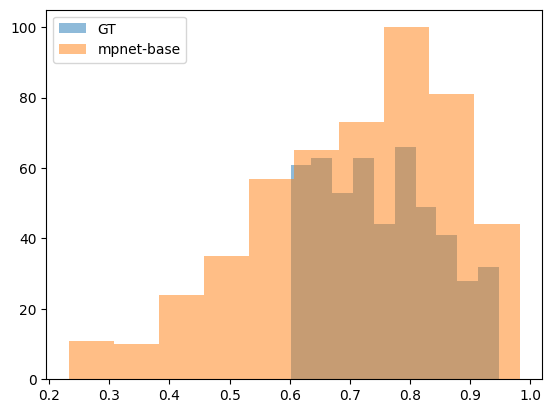

In [87]:
plt.hist(data.similarity.to_numpy()[:test_len], alpha=0.5, label='GT', density=False)
plt.hist(np.array(similarities_sentence_transformers), alpha=0.5, label='mpnet-base', density=False)
plt.legend();
print(np.corrcoef(data.similarity.to_numpy()[:test_len], np.array(similarities_sentence_transformers)))

Among neural networks based approaches this one is the best thus far

Probably the least computationally expensive way is to just compute BLEU score:

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

similarities_bleu = [] 

for i in tqdm(range(len(data))):
    row = data.iloc[i]
    sentence1 = row.reference
    sentence2 = row.translation
    similarities_bleu.append(sentence_bleu([sentence1], sentence2))

[[1.         0.47805723]
 [0.47805723 1.        ]]


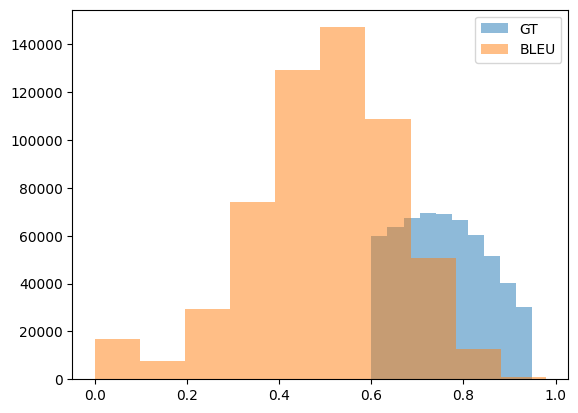

In [71]:
plt.hist(data.similarity.to_numpy(), alpha=0.5, label='GT')
plt.hist(np.array(similarities_bleu), alpha=0.5, label='BLEU')
plt.legend();
print(np.corrcoef(data.similarity.to_numpy(), np.array(similarities_bleu)))

The easiest way to estimate toxicity levels would be to utilize original paper's evaluation metrics: https://github.com/s-nlp/detox/blob/main/emnlp2021/metric/metric.py

In [104]:
# Code adapted from https://github.com/s-nlp/detox/blob/main/emnlp2021/metric/metric.py
ARGS = {'batch_size': 32, 'threshold': 0.8}

model_name = 'SkolkovoInstitute/roberta_toxicity_classifier'

tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)


def classify_preds(preds, soft=False):
    results = []

    for i in range(0, len(preds), ARGS['batch_size']):
        batch = tokenizer(preds[i:i + ARGS['batch_size']], return_tensors='pt', padding=True)
        with torch.inference_mode():
            logits = model(**batch).logits
        if soft:
            result = torch.softmax(logits, -1)[:, 1].cpu().numpy()
        else:
            result = (logits[:, 1] > ARGS['threshold']).cpu().numpy()
        results.extend([1 - item for item in result])
    return results

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Check repeatability:

In [107]:
low_tox_estimate, high_tox_estimate = [], []

low_tox_gt, high_tox_gt = [], []
for i in tqdm(range(test_len)):
    row = data.iloc[i]
    low_tox, high_tox = row.reference, row.translation
    if row.ref_tox > row.trn_tox:
        low_tox, high_tox = row.translation, row.reference
    low_tox_gt.append(min(row.ref_tox, row.trn_tox))
    high_tox_gt.append(max(row.ref_tox, row.trn_tox))
    _low, _high = classify_preds([low_tox, high_tox], soft=True) # This is not the best use of batching, todo - rewrite it in the src/ 
    low_tox_estimate.append(1 - _low)
    high_tox_estimate.append(1 - _high)

  0%|          | 0/500 [00:00<?, ?it/s]

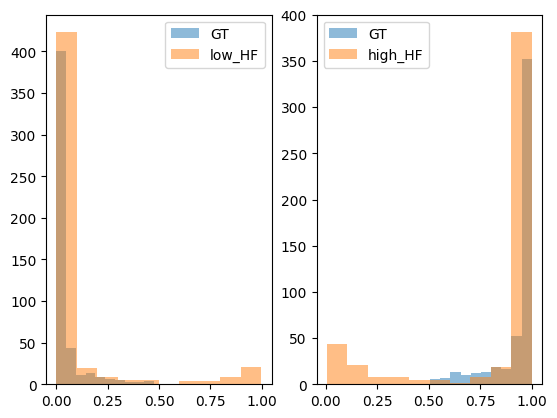

In [108]:
plt.subplot(121)
plt.hist(low_tox_gt, alpha=0.5, label='GT')
plt.hist(low_tox_estimate, alpha=0.5, label='low_HF')
plt.legend();
plt.subplot(122)
plt.hist(high_tox_gt, alpha=0.5, label='GT')
plt.hist(high_tox_estimate, alpha=0.5, label='high_HF')
plt.legend();

Repeatability is confirmed (the non-overlapping tails can be cleaned from dataset in the case of poor performance, or get their labels reassigned)

## Conclusions:

1. As similarity measure one could use BLEU and (as a final benchmarking, since it is expensive in resources) mpnet-base (sentence-transformers/all-mpnet-base-v2)
2. Whereas in similarity estimates it is possible to find options not involving the methods fom the original paper, for toxiciy estimation it is better to stick to the author's approach as this task anyway requires a neural network (or human evaluation)